# Identifying Splicing Regulatory Motifs Using Convolutional Neural Networks

Notes:

We can treat the convolutional filters learned by a neural network as something like position-weight matrices or motifs. This is done by feeding every test sequence into a filter, extracting the subsequence that has the maximum output value for the filter, and finally averaging all of these maximum output subsequences.

Higher-order features might also be visualized somehow...

Since training data all have the same length, average and sum layers are equivalent.

Model architectures:
1. convolutional -> average over time -> sum over filters -> softmax
2. convolutional -> dropout -> average over time -> sum over filters -> softmax
3. convolutional -> recurrent -> average over time -> sum over filters -> softmax
4. convolutional -> convolutional -> average over time -> sum over filters -> softmax

## Part 1: Learning Alternative 5' Splicing Motifs

We will be starting out by using the same dataset that is used for the Cell 2015 paper.

1. Train convolutional neural network models for splice site prediction.
2. For each convolutional filter:
    - feed all test seqeunces to that filter
    - if the output for that sequence is above zero somewhere, 

In [1]:
# Step 1: loading the data (just copied from the previous stuff)
# or, just load the model and not redo the training?


%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle



Using Theano backend.


In [2]:
import keras
keras.__version__

'1.1.0'

## Model 1: Single Convolutional Layer

200 filters of length 6, followed by global average pooling, followed by linear layer

In [3]:
num_filters = [200,64,32]
filter_length = [6,6,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))
model1.compile(loss='binary_crossentropy',
              optimizer='adam')


/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 35s - loss: 0.6237 - val_loss: 0.5925
Epoch 2/50
212035/212035 [==============================] - 33s - loss: 0.5869 - val_loss: 0.5785
Epoch 3/50
212035/212035 [==============================] - 33s - loss: 0.5781 - val_loss: 0.5725
Epoch 4/50
212035/212035 [==============================] - 34s - loss: 0.5733 - val_loss: 0.5727
Epoch 5/50
212035/212035 [==============================] - 35s - loss: 0.5702 - val_loss: 0.5667
Epoch 6/50
212035/212035 [==============================] - 33s - loss: 0.5681 - val_loss: 0.5649
Epoch 7/50
212035/212035 [==============================] - 34s - loss: 0.5663 - val_loss: 0.5637
Epoch 8/50
212035/212035 [==============================] - 33s - loss: 0.5649 - val_loss: 0.5629
Epoch 9/50
212035/212035 [==============================] - 33s - loss: 0.5639 - val_loss: 0.5608
Epoch 10/50
212035/212035 [==============================] - 34s - 

/usr/local/lib/python2.7/dist-packages/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


In [6]:
# test on train set
predictions = model1.predict(X1_test)

In [7]:
r2_score(Y2_test, predictions)

0.45903013332063702

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


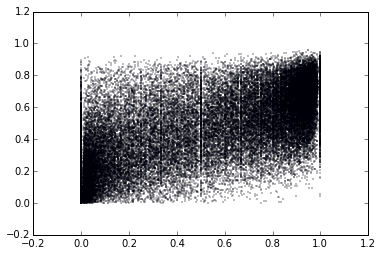

In [8]:
plt.scatter(Y2_test, predictions, s=0.1)

In [9]:
from keras import backend as K

In [15]:
# now, we try to identify the motifs...
def get_max_filters(model, X_test):
    """
    Returns the maximum position of each convolutional filter in the first layer
    for each input.
    """
    f0 = K.function([model1.layers[0].input], [model1.layers[0].output])
    f1 = K.function([model1.layers[0].input], [model1.layers[1].output])
    # conv_out is a 3d array - dim is (input) x (position) x (filter)
    # layer_out is a 2d array - dim is (# inputs) x (# filters)
    conv_out = f0([X_test])[0]
    layer_out = f1([X_test])[0]
    n_inputs, n_filters = layer_out.shape
    subseqs = []
    for i in range(n_filters):
        conv_out_i = conv_out[:,:,i]
        max_pos = np.argmax(conv_out_i, 1)
        subseqs.append(max_pos)
    return subseqs, layer_out
    # positive regulators: positive coefficient in dense layer

def get_avg_filters(model, X_test):
    """
    Returns the average maximum activation
    """
    x, layer_outs = get_max_filters(model, X_test)
    avg_filters = []
    n_inputs, n_filters = layer_outs.shape
    # i is the filter, k is the input
    for i in range(n_filters):
        nonzeros = np.nonzero(layer_outs[:,i]>0)[0]
        avg_filter1 = sum(X1_test[k,x[i][k]:(x[i][k]+6),:] for k in nonzeros)
        avg_filters.append(avg_filter1/(len(nonzeros)+0.0001))
    return avg_filters

In [16]:
x, layer_outs = get_max_filters(model1, X1_test)

In [17]:
avg_filters = []
# i is the filter, k is the input
for i in range(200):
    nonzeros = np.nonzero(layer_outs[:,i]>0)[0]
    avg_filter1 = sum(X1_test[k,x[i][k]:(x[i][k]+6),:] for k in nonzeros)
    avg_filters.append(avg_filter1/(len(nonzeros)+0.0001))

In [18]:
avg_filters[0]

array([[  6.14837378e-01,   1.35848485e-01,   1.79460011e-01,
          6.98541236e-02],
       [  7.18407658e-02,   4.47145857e-01,   1.53255255e-03,
          4.79480823e-01],
       [  2.56806614e-01,   3.06907838e-01,   1.32253609e-02,
          4.23060185e-01],
       [  3.23746996e-01,   6.62214064e-04,   2.17395417e-02,
          6.53851247e-01],
       [  3.17843830e-01,   3.84084157e-03,   3.48135394e-03,
          6.74833972e-01],
       [  5.85983765e-01,   1.44532950e-01,   2.03432161e-01,
          6.60511228e-02]])

In [19]:
avg_filters[1]

array([[ 0.5795431 ,  0.31034353,  0.06070667,  0.0494067 ],
       [ 0.06163104,  0.67831877,  0.1112264 ,  0.14882378],
       [ 0.07747741,  0.04076666,  0.09756834,  0.78418759],
       [ 0.51330906,  0.21758569,  0.16108585,  0.10801939],
       [ 0.50749873,  0.08489124,  0.13884435,  0.26876568],
       [ 0.25401347,  0.06046143,  0.27870739,  0.40681771]])

In [20]:
model1.save_weights('../data/convolutional-sum-motif-detect.h5')
model_json = model1.to_json()
with open('../data/convolutional-sum-motif-detect.json', 'w') as f:
    f.write(model_json)

In [21]:
for i in range(avg_filter.shape[0]):
    print ' '.join(map(str, avg_filter[i,:]))

NameError: name 'avg_filter' is not defined

http://www.cbs.dtu.dk/biotools/Seq2Logo-2.0/tmp/252916b57687920afa661cf0cf490dfbae4081b7/output-001.png

In [22]:
filter1 = model1.layers[0].get_weights()[0][:,0,:,0]

In [23]:
filter1

array([[ 0.12546447, -0.03738094,  0.00936273, -0.32156071],
       [-0.01567492, -0.72232282, -0.85980809,  0.28370425],
       [ 0.02071684, -1.08412063, -0.48953575,  0.31176415],
       [-0.15143615,  0.24885643, -0.70720243,  0.08852417],
       [-0.31523269,  0.41804168, -0.83348805,  0.13278809],
       [ 0.16357242,  0.08442737,  0.02846973, -0.35432205]], dtype=float32)

In [24]:
for i in range(filter1.shape[0]):
    print '\t'.join(map(str, filter1[i,:]))

0.125464	-0.0373809	0.00936273	-0.321561
-0.0156749	-0.722323	-0.859808	0.283704
0.0207168	-1.08412	-0.489536	0.311764
-0.151436	0.248856	-0.707202	0.0885242
-0.315233	0.418042	-0.833488	0.132788
0.163572	0.0844274	0.0284697	-0.354322


http://www.cbs.dtu.dk/biotools/Seq2Logo-2.0/tmp/546705458fba2202f49bfa56be68caddf766ccfe/output-001.png

In [25]:
# TODO: generate sequence logos for all of these sequences...
# but first, we'll save this logo data...
np.save('../data/convolutional-sum-motif-data.np', avg_filters)

Questions/Notes:
- what does the experimental motif mean?
- what does the filter-derived motif mean?
- is there a scalable way of generating motifs? like a good python library that's easy to install? or do I have to create one???

In [13]:
nonzeros

array([    0,     1,     2, ..., 53006, 53007, 53008])

In [14]:
X1_test.shape

(53009, 25, 4)